In [27]:
pwd

'/content'

In [28]:
%cd /content/drive/MyDrive/CV_seminar_project

[Errno 2] No such file or directory: '/content/drive/MyDrive/CV_seminar_project'
/content


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import os
import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

In [31]:
device

'cuda'

In [32]:
root_path = '/content/drive/MyDrive/Colab Notebooks/dna/original-1'
train_path = '/content/drive/MyDrive/Colab Notebooks/dna/original-1/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/dna/original-1/test'

# pytorch 데이터셋 클래스 실습

### 1. 파이토치 데이터 셋 클래스를 직접 만들어보자.

파이토치 데이터 셋 클래스는 init, getitem, len 특수 메소드 3개를 요구한다.   
 항상 같은 포맷을 만드는 습관이 중요하다. 
> 따라서 root_path, mode(train or validation or test), transform(전처리&Augmentation) 3개의 입력을 받아 data와 label을 출력하는 클래스를 만들도록하자.


In [33]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os 

class Custom_dataset(Dataset):
  def __init__(self, root_path, mode, transforms):
    self.all_data = sorted( glob.glob( os.path.join(root_path, mode, '*', '*') ) ) # 전체 경로
    self.transforms = transforms

  def __getitem__(self, index):
    if torch.is_tensor(index): # 인덱스가 tensor형태일 수 있는 것을 방지
      index = index.tolist()

    data_path = self.all_data[index] # 인덱스가 부여된 데이터 1개
    image = cv2.imread(data_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 라이브러리의 BGR 형식을 RGB로 permute

    # transfrom 적용
    if self.transforms is not None:
      augmentation = self.transforms(image = image)
      image = augmentation['image']

    # 이미지의 이름을 이용하여, label 부여하기
    if 'dolphin' in data_path:
      label = 0
    elif 'shark' in data_path:
      label = 1
    else:
      label = 2

    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

### 2. 전처리와 Augmentation을 적용한다.
> Normalize: 픽셀 값에 대해 (X - mean)/std를 진행하며, 이때 통계 값은 ImageNet 데이터 셋의 RGB 통계값을 이용할 것이다.
>   
> 텐서화: 파이토치는 tensor자료 형을 이용하므로 totensor를 해준다.   
>   
> augmentation: trainset에만 적용한다.


In [34]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

train_transforms = A.Compose([
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = Custom_dataset(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = Custom_dataset(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = Custom_dataset(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=8, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=8, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=8, shuffle = False, num_workers=0)

# week4 과제
아래와 같이 원래 0~255 픽셀 값을 가진 귀여운 돌고래 이미지는 Augmentation이 적용되어(train_class[0][0]) 이미지가 변형 되었다.   
**train_class[0][0] 데이터**를 시각화 할 수 있도록 시각화 라이브러리가 요구하는 numpy 타입의 올바른 이미지 데이터로 되돌리는 역함수를 만들어 시각화 해오는 것.   

결과물에 대해서는 week4 pdf의 과제 설명에 있는 이미지를 보시면 이해될 것입니다.

In [35]:
train_class.all_data[0]

'/content/drive/MyDrive/Colab Notebooks/dna/original-1/train/dolphin/dolphin_000.jpg'

In [36]:
train_class[0][0] # 역함수를 이용해 이것을 시각화 해주세요.

tensor([[[ 1.3927,  1.3070,  1.4098,  ...,  0.6049,  0.5707,  0.5878],
         [ 1.3927,  1.3242,  1.4098,  ...,  0.6049,  0.6049,  0.5878],
         [ 1.3070,  1.4098,  1.4783,  ...,  0.6049,  0.6049,  0.6049],
         ...,
         [ 0.6049,  0.8789,  0.8789,  ...,  0.4166,  0.4508,  0.4679],
         [ 0.4679,  0.7248,  0.7248,  ...,  0.4337,  0.4851,  0.4851],
         [ 0.3652,  0.6392,  0.6221,  ...,  0.4337,  0.4851,  0.4851]],

        [[ 1.9384,  1.9034,  1.9909,  ...,  1.6583,  1.6232,  1.6232],
         [ 1.9209,  1.8683,  1.9909,  ...,  1.6758,  1.6583,  1.6408],
         [ 1.7983,  1.9209,  2.0609,  ...,  1.6758,  1.6758,  1.6758],
         ...,
         [ 1.4832,  1.7633,  1.7983,  ...,  1.6232,  1.6583,  1.6583],
         [ 1.3431,  1.6232,  1.6408,  ...,  1.6408,  1.6758,  1.6758],
         [ 1.2381,  1.5182,  1.5357,  ...,  1.6408,  1.6758,  1.6758]],

        [[ 1.0365,  0.9319,  0.9668,  ..., -0.5844, -0.6018, -0.5844],
         [ 1.0365,  0.9494,  0.9668,  ..., -0

In [37]:
import numpy as np 
from torchvision.transforms import ToPILImage

In [38]:
mean_list=[0.485, 0.456, 0.406]
std_list=[0.229, 0.224, 0.225]

In [39]:
train_class[0][0].shape

torch.Size([3, 224, 224])

In [40]:
img_to_c = np.transpose(train_class[0][0],(2,1,0)) #채널축변경

In [41]:
img_to_c

tensor([[[-0.9705,  0.3102,  1.8731],
         [-0.7308,  0.5728,  2.1520],
         [-0.7993,  0.5378,  2.1694],
         ...,
         [-1.5699,  0.1702,  2.2740],
         [-1.5185,  0.2052,  2.3088],
         [-1.5185,  0.2052,  2.3088]],

        [[-0.8678,  0.4153,  1.9777],
         [-0.6623,  0.6604,  2.2566],
         [-0.6965,  0.6429,  2.2740],
         ...,
         [-1.5699,  0.1702,  2.2740],
         [-1.5185,  0.2052,  2.3088],
         [-1.5185,  0.2052,  2.3088]],

        [[-0.7650,  0.5378,  2.1171],
         [-0.4911,  0.8179,  2.3960],
         [-0.5596,  0.8004,  2.4308],
         ...,
         [-1.5870,  0.1527,  2.2566],
         [-1.5528,  0.1877,  2.2914],
         [-1.5357,  0.1877,  2.2914]],

        ...,

        [[ 0.5364,  1.5007,  2.4308],
         [ 0.5878,  1.5882,  2.5529],
         [ 0.5707,  1.5707,  2.6400],
         ...,
         [-1.1589,  0.4153,  2.3088],
         [-1.1418,  0.4153,  2.3088],
         [-1.1418,  0.4153,  2.3088]],

        [[

In [42]:
for i in range(3):
  if i == 0:
    img_to_c[:][:][0] = img_to_c[:][:][0]*std_list[i]+mean_list[i]
  if i == 1:  
    img_to_c[:][:][1] = img_to_c[:][:][1]*std_list[i]+mean_list[i]
  if i == 2:
    img_to_c[:][:][2] = img_to_c[:][:][2]*std_list[i]+mean_list[i]

## unnormalize

In [43]:
img_to_c_arr = np.array(img_to_c*255)
#픽셀값 *255

In [44]:
img_to_c_arr

array([[[  66.99999 ,  141.79054 ,  233.05557 ],
        [  81.      ,  157.12537 ,  249.34004 ],
        [  76.99999 ,  155.08072 ,  250.3578  ],
        ...,
        [  31.999998,  133.61197 ,  256.46448 ],
        [  35.000004,  135.65662 ,  258.5     ],
        [  35.000004,  135.65662 ,  258.5     ]],

       [[  66.71144 ,  140.      ,  229.24568 ],
        [  78.44943 ,  154.      ,  245.17458 ],
        [  76.493095,  153.      ,  246.17012 ],
        ...,
        [  26.606636,  126.      ,  246.17012 ],
        [  29.541134,  128.      ,  248.16125 ],
        [  29.541134,  128.      ,  248.16125 ]],

       [[  59.63535 ,  134.38715 ,  224.99998 ],
        [  75.355865,  150.45857 ,  241.      ],
        [  71.42574 ,  149.4541  ,  243.      ],
        ...,
        [  12.473773,  112.28893 ,  233.      ],
        [  14.438846,  114.29785 ,  235.      ],
        [  15.421373,  114.29785 ,  235.      ]],

       ...,

       [[ 136.79037 ,  382.67856 ,  619.86664 ],
        [ 1

In [45]:
a = img_to_c_arr.astype(int)

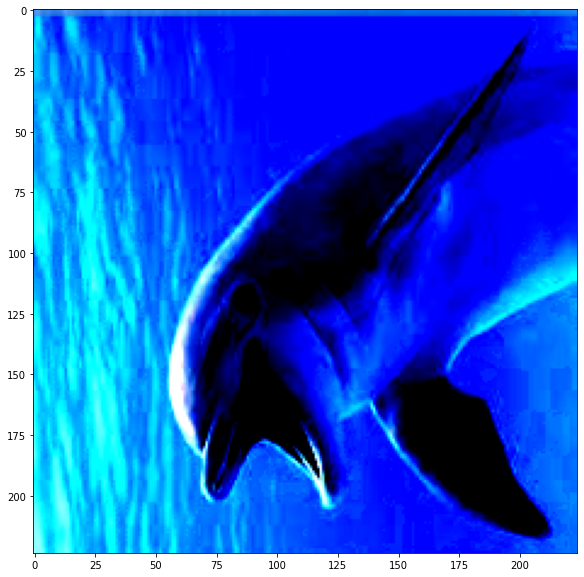

In [46]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

grid = gridspec.GridSpec(1,1)#그래프를 그릴 도화지 개수
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace= 0.4, hspace=0.4) #그래프 간의 거리 조절

ax0 = plt.subplot(grid[0])
ax0.imshow(a)

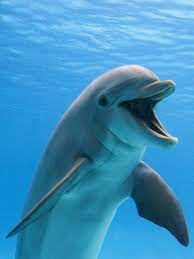

In [47]:
from PIL import Image as PILImage
PILImage.open(train_class.all_data[0])

In [48]:
# numpy == H W C
# tensor = C H W